# Сервис для статистического анализа потока посетителей.
## Пол, возраст и интенсивность посещений.

In [1]:
import models
import cv2
import os

fdet = models.FaceDetection()
fdes = models.FaceDescription('data/model_weights/LandmarkFace.dat', 'data/model_weights/ResNetFace.dat')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Нахождение и распознавание лиц.
## Благодоря технологиям верифекации человека по лицу наш сервис всегда знает, кто когда зашел и ушел, а так же сколько человек сейчас находится в помещении.
### Пример "Face Detection".
<img src="data/images/facedetect.png" width="50%">

In [2]:
# cap = cv2.VideoCapture(0)

# facesV = []

# while True:

#     ret, frame = cap.read()

#     dets = fdet(frame)
    
#     facesV = fdes(frame, dets = dets)
    
#     for k, d in enumerate(dets):
#         cv2.rectangle(frame, (d.left(), d.top()), (d.right(), d.bottom()), (0, 0, 255), 1, 8, 0)

#     cv2.imshow('capture', frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cv2.destroyAllWindows()
# cap.release()

# Описание лиц 128-мерным вектором.
## После нахождения лиц на изображении нейронная сеть типа ResNet-34 раскладывает его на 128-мерный вектор. После мы можем их сравнивать на схожесть. 

### Пример "Face Description".
<img src="data/images/facesPlot.png" width="50%">

In [3]:
# %matplotlib inline

# import matplotlib.pyplot as plt
# plt.figure(figsize = (20,10), dpi = 400)

# for i,face in enumerate(facesV):
#     plt.plot(face + i, label = 'Face_' + str(i))
# plt.legend()
# plt.xticks([])
# plt.yticks([])

# plt.show()

In [4]:
AGS_model = models.WideResNetCreater()()
AGS_model.load_weights(os.path.join("data/model_weights/", "weights.18-4.06.hdf5"))

/Users/nativesmell/Documents/Work/Hack_university/models.py:248: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), filters=16, strides=(1, 1), padding="same", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., use_bias=False)`
  bias=self._use_bias)(inputs)
/Users/nativesmell/Documents/Work/Hack_university/models.py:196: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(1, 1), padding="same", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., use_bias=False)`
  bias=self._use_bias)(convs)
/Users/nativesmell/Documents/Work/Hack_university/models.py:207: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), strides=(1, 1), padding="same", kernel_initializer="he_normal", kernel_regularizer=<keras.reg..., use_bias=False)`
  bias=self._use_bias)(convs)
/Users/nativesmell/Documents/Work/Hack_university/models.py:215: UserWarning: Update your `Conv2D` call to the

In [5]:
from IPython.display import Image, display, SVG

fig = SVG(models.visModel(AGS_model, savePath = 'data/images/', name = 'AGS_structure'))

# Классификация по полу и оценка возраста
## Для классификации пола и  оценки возраста также используется сеть типа ResNet, но в этот раз мы имеем два выхода, один бинарный, он говорит мужчина перед нами или женщина, а второй выдает вектор, сумма координат которого даст оценку возраста.
### Структура модели.
<img src="data/images/AGS_structure.png" width="100%">

In [6]:
IRAM = models.IntensRecModelCreater(input_dim = 2, power = 128)()
fig = SVG(models.visModel(IRAM, savePath = 'data/images/', name = 'IRAM_structure'))

# Для анализа временных последовательностей мы используем рекуррентные нейронные сети
## Они позволяют нам предсказывать следующие во времени события
### Пример рекуррентной сети

<img src="data/images/IRAM_structure.png" width="30%">


# Мы сгенерировали синтетическую выборку с посещаемостью 
## Она содержит ровно 1 год, где каждый объект - это 1 час и метка дня недели

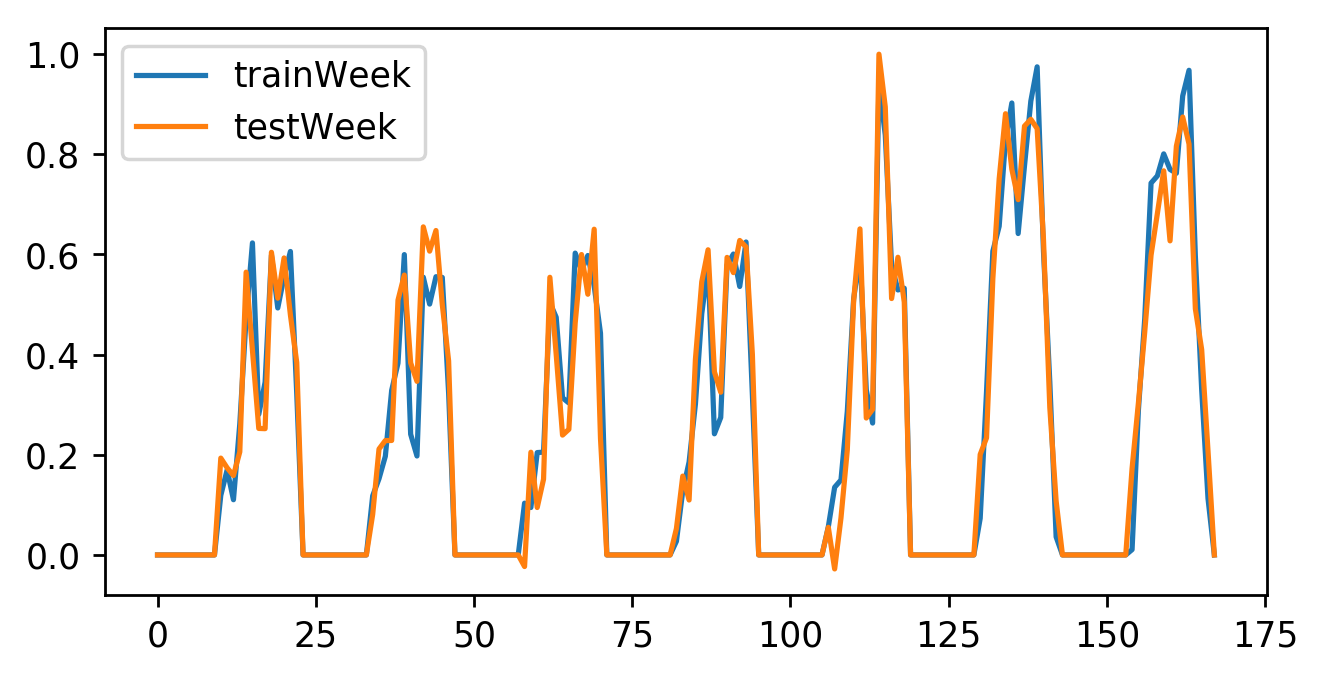

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import dataGenerator as gen

data_set, weekTest = gen.generate()

plt.figure(figsize = (6,3), dpi = 250)
plt.plot([d[0] for d in data_set[:24*7]], label = 'trainWeek')
plt.plot([d[0] for d in weekTest], label = 'testWeek')
plt.legend()
plt.yticks()
plt.show()


In [8]:
X, Y = models.pad_sequences(data_set)

Y = [d[0] for d in Y]

#history = models.fitModel(IRAM, X , Y, 'data/model_weights/RNN_Analys', 
#                          val_rate = 0.1, epochs = 1000, batch_size = 128)

IRAM = models._load_model('data/model_weights/RNN_Analys')

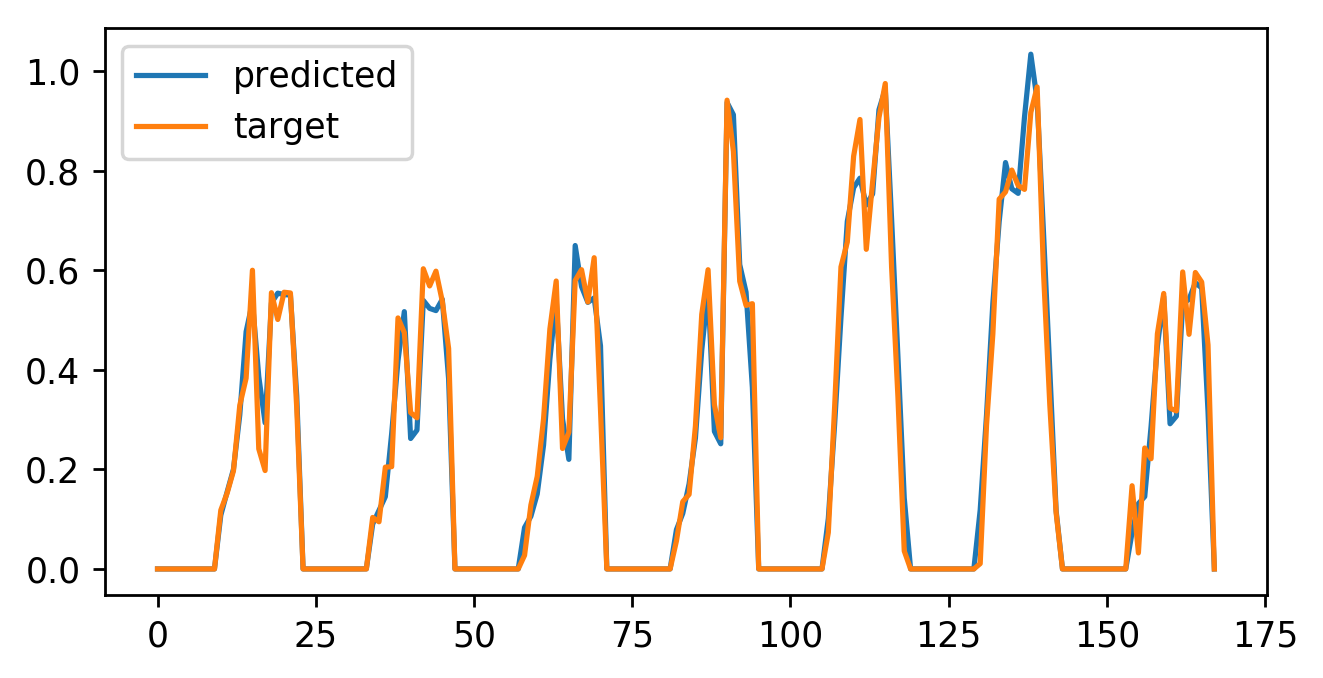

In [9]:
YP = IRAM.predict(X)

plt.figure(figsize = (6,3), dpi = 250)

plt.plot(YP[:24*7], label = "predicted")
plt.plot(Y[:24*7], label = "target")
plt.legend()
plt.show()

In [10]:
X, Y = models.pad_sequences(weekTest)

Y = [d[0] for d in Y]

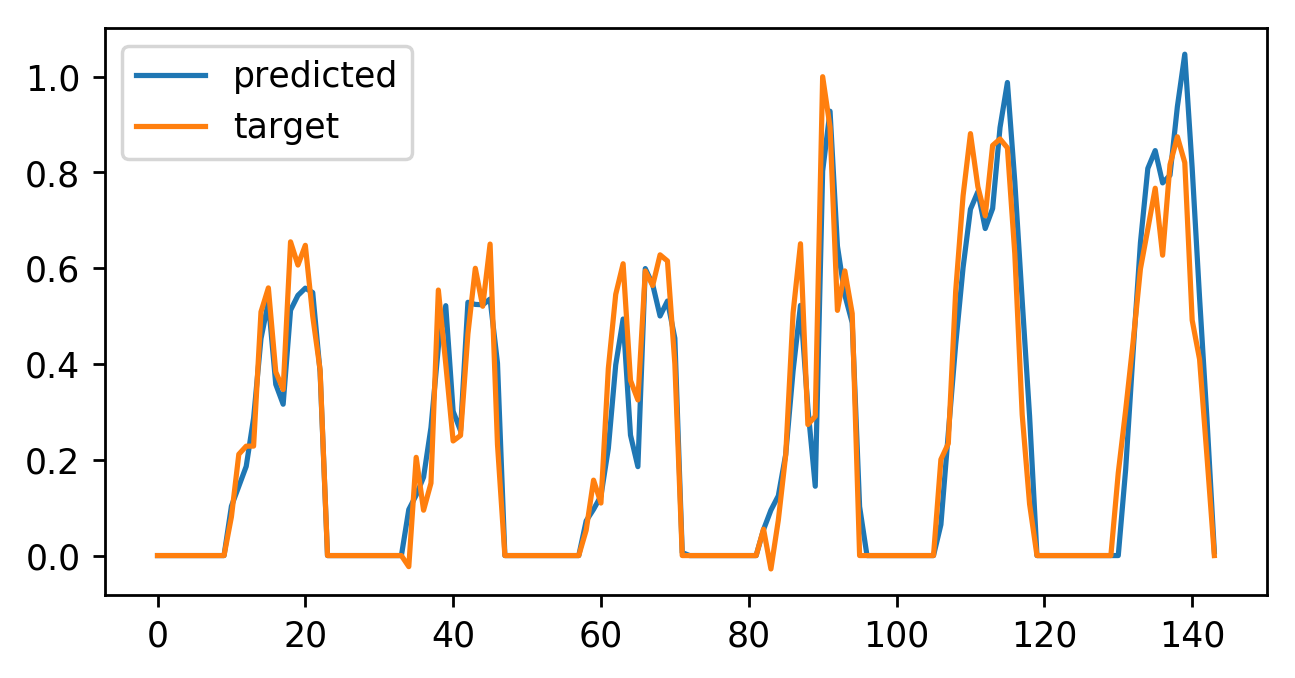

In [11]:
import numpy as np

_x = weekTest[:24]
YP = []
for i in range(len(weekTest) - 24):
    p = IRAM.predict(np.array([_x]))
    _x = _x[1:]
    _x.append([float(p),weekTest[24 + i][1]])
    YP.append(float(p))

plt.figure(figsize = (6,3), dpi = 250)

plt.plot(YP, label = "predicted")
plt.plot(Y, label = "target")
plt.legend()
plt.show()

In [12]:
print(sum((np.array(YP) - np.array(Y))**2) / len(Y))

0.00656031258763336
